# GPT2-xl installation



Import GPT2-xl with the available RAM.
Setup and import all packages.

In [ ]:
import sys
in_colab = 'google.colab' in sys.modules

In [ ]:
#import the useful libraries if you are working on google colab
if in_colab:
    !git clone https://github.com/leodana2000/finding_gender_direction.git
    !pip install transformers
    !pip install accelerate

In [ ]:
if in_colab:
    sys.path.append("/content/finding-gender-direction")
else:
    #use your own PATH
    PATH = None
    sys.path.append(PATH)

from finding_gender_direction.hyperplane_computation import utils
from finding_gender_direction.hyperplane_computation import inference_time_modification
from finding_gender_direction.hyperplane_computation import store_test_hyperplane

import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import GPT2TokenizerFast, GPT2LMHeadModel

In [ ]:
#when debugging, use gpt2 to be faster
debugging = False
torch.set_grad_enabled(False)

if debugging:
  tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
  model = GPT2LMHeadModel.from_pretrained('gpt2')
else:
  tokenizer = GPT2TokenizerFast.from_pretrained('gpt2-xl')
  model = GPT2LMHeadModel.from_pretrained('gpt2-xl', device_map="auto", offload_folder="offload", offload_state_dict=True)

model.eval()

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

model.to(device)

dict = {
    'device': device,
    'model': model,
    'tokenizer': tokenizer,
}

# Load Data

In [6]:
D = pd.read_csv("finding_gender_direction/Data/Train_Data.csv")

Train = D[D['train'] == 1].loc[:, ['examples', 'gender']].values.tolist()
Test = D[D['train'] == 0].loc[:, ['examples', 'gender']].values.tolist()
Data_m = D[D['gender'] == 1]['examples'].values.tolist()
Data_f = D[D['gender'] == -1]['examples'].values.tolist()
Learn = D[not(D['train'] == 0 and D['data_lbl'] == 'name')].loc[:, ['examples', 'gender', 'data_lbl']].values.tolist()
Test_name = D[D['train'] == 0 and D['data_lbl'] == 'name'].loc[:, ['examples', 'gender']].values.tolist()

#batching
batch_size = 1024
Nb_ex = len(Train)
Nb_batch = Nb_ex//batch_size + 1
Train = [Train[i*batch_size:min((i+1)*batch_size, Nb_ex)] for i in range(Nb_batch)]

Nb_ex = len(Learn)
Nb_batch = Nb_ex//batch_size + 1
Learn = [Learn[i*batch_size:min((i+1)*batch_size, Nb_ex)] for i in range(Nb_batch)]

In [9]:
Test = pd.read_csv("Test_Data.csv")

example_prompts_A = list(Test[Test['data_num'] == 'a']['question'])
example_prompts_B = list(Test[Test['data_num'] == 'b']['question'])
example_prompts_C = list(Test[Test['data_num'] == 'c']['question'])
example_prompts_D = list(Test[Test['data_num'] == 'd']['question'])

target_tokens_A = tokenizer(list(Test[Test['data_num'] == 'a']['target'])).input_ids
target_tokens_B = tokenizer(list(Test[Test['data_num'] == 'b']['target'])).input_ids
target_tokens_C = tokenizer(list(Test[Test['data_num'] == 'c']['target'])).input_ids
target_tokens_D = tokenizer(list(Test[Test['data_num'] == 'd']['target'])).input_ids

In [ ]:
#list of tokens counted as "good" answers
text_lists = [["he", " he", "He", " He",
                 "him", " him", "Him", " Him",
                 "his", " his", "His", " His",
                 "male", " male", "Male", " Male",
                 "son", " son", "Son", " Son",
                 "father", " father", "Father", " Father",
                 "boy", " boy", "Boy", " Boy",
                 ],
              ["she", " she", "She", " She",
               "her", " her", "Her", " Her",
               "female", " female", "Female", " Female",
               "daugther", " daugther", "Daugther", " Daugther",
               "mother", " mother", "Mother", " Mother",
               "girl", " girl", "girl", " girl",]]
token_lists = [tokenizer(text_list).input_ids for text_list in text_lists]
token_lists = [[[token[0]] for token in token_lists[0]], [[token[0]] for token in token_lists[1]]]

# Learning and Testing Hyperplane

We learn the leace direction for the mean, quantile and for the Logistic Regression. 
The number is the Data number (1 = words, 2 = names). By default they are learnt after the layer norm of the attention module, but $res$ means the direction is learnt in the residual stream directly. In this case, we don't learn the Logistic Regression because it diverges (This could be fixed but is unimportant).\
\
We can learn on the full dataset, or only on a subset: for the full, use $Data$, otherwise $Train$. For the second dataset, we want to use $Train_2$ because $Test_2 = Data_2-Train_2$. 

In [ ]:
# Learn the estimators on the attention
eraser_mean, eraser_quantile, eraser_probe = store_test_hyperplane.storing_hyperplanes(Learn, post_layer_norm = True, **dict)

# Learning the estimators in the residual stream
eraser_mean_res, eraser_quantile_res, _ = store_test_hyperplane.storing_hyperplanes(Learn, post_layer_norm = False, **dict)


We can now measure, at each layer, the accuracy of our hyperplane! 

In [ ]:
metric_q = utils.probe_eval(eraser_quantile)
metric_m = utils.probe_eval(eraser_mean)
metric_p = utils.probe_eval(eraser_probe)

acc_data = store_test_hyperplane.hyperplane_acc(Learn, [metric_q, metric_m, metric_p], **dict)

In [ ]:
nb_layers = len(model.transformer.h)

fig, axes = plt.subplots(1, 1, figsize=(5, 5), sharex = True, sharey = True)

axes.plot(acc_data[0], label = 'Quantile hyperplane')
axes.plot(acc_data[1], label = 'Mean hyperplane')
axes.plot(acc_data[2], label = 'Logistic hyperplane')
axes.plot([0, nb_layers-1],[0.5, 0.5], color = 'black', label = 'Random hyperplane')
axes.set_title("Hyperplanes' accuracy on gendered words")
axes.set_xlabel("Layer")
axes.set_ylabel("Accuracy")
axes.set_ylim(-0.1, 1.1)
axes.legend()

plt.tight_layout()
plt.show()

# Learning and Testing Directions

Similarly to the last section, we learn the leace and Logistic direction but this time on pairs of example instead of examples directly.\ 
$Y = X_{male} - X_{female}$\
\
Thus:
* we need paired examples, thus we can't use the dataset 2,
* we have $b_{mean} = b_{quantile} = 0$,

In [ ]:
eraser_dir_mean_1, eraser_dir_probe_1 = store_test_hyperplane.storing_directions([[Data_m_1], [Data_f_1]], post_layer_norm = True, **dict)

In [ ]:
metric_m = utils.leace_eval(eraser_dir_mean_1)
metric_p = utils.leace_eval(eraser_dir_probe_1)

acc_data = store_test_hyperplane.direction_acc([[word[0] for word in Data_m_1], [word[0] for word in Data_f_1]], [metric_m, metric_p], **dict)

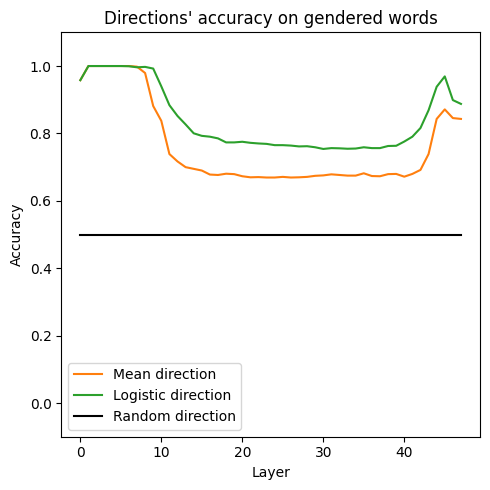

In [ ]:
nb_layers = len(model.transformer.h)

fig, axes = plt.subplots(1, 1, figsize=(5, 5), sharex = True, sharey = True)

axes.plot(acc_data[0], label = 'Mean direction', color = 'C1')
axes.plot(acc_data[1], label = 'Logistic direction', color = 'C2')
axes.plot([0, nb_layers-1],[0.5, 0.5], color = 'black', label = 'Random direction')
axes.set_title("Directions' accuracy on gendered words")
axes.set_xlabel("Layer")
axes.set_ylabel("Accuracy")
axes.set_ylim(-0.1, 1.1)
axes.legend()

plt.tight_layout()
plt.show()

# Leace erasure

In [ ]:
#Visualise if the test examples have good probability / accuracy
prompts = example_prompts_A
test_prompt = False

if test_prompt:
  tokenized_sentences = [tokenizer(prompt, return_tensors = 'pt')["input_ids"].to(device) for prompt in prompts]

  for tokenized_sentence, prompt in zip(tokenized_sentences, prompts):
    print(prompt)
    print(utils.show_proba(torch.softmax(model(tokenized_sentence).logits[0, -1], dim = -1), tokenizer, nb_tokens = 5, decode = True))

In [ ]:
#We compute all of the leace fitters and erasers
nb_layers = len(model.transformer.h)
layer_list = [[i for i in range(0, 9)]]
layer_res_list = [[10]]
lbds = torch.Tensor([i/10 for i in range(0, 61, 1)])

attention_only = True

In [ ]:
score_A = inference_time_modification.fast_score(
    example_prompts_A, token_lists, eraser_mean_1, eraser_mean_1_res, 
    target_tokens_A, layer_list, layer_res_list, lbds = lbds, 
    attention_only = attention_only, **dict
)
score_B = inference_time_modification.fast_score(
    example_prompts_B, token_lists, eraser_mean_1, eraser_mean_1_res, 
    target_tokens_B, layer_list, layer_res_list, lbds = lbds, 
    attention_only = attention_only, **dict
)
score_C = inference_time_modification.fast_score(
    example_prompts_C, token_lists, eraser_mean_2, eraser_mean_2_res, 
    target_tokens_C, layer_list, layer_res_list, lbds = lbds, 
    attention_only = attention_only, **dict
)

In [ ]:
#just in case come hook is problematic
for module in model.transformer.h:
  module._forward_pre_hooks.clear()
  module.attn._forward_pre_hooks.clear()
  module.attn._forward_hooks.clear()

In [ ]:
#Plots the graphs depending if we intervene in the attention or not.

if attention_only:
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex = True, sharey = True)
    dir = 1
    score = score_A

    s = torch.mean(torch.cat([s[0] for s in score], dim = 0), dim = -1).T.to('cpu')
    acc = [torch.mean(torch.Tensor([[1 if (score_l[1] - score_l[0])*dir > 0 else 0 for score_l in sub_score[0].T] for sub_score in scOre]), dim = -1).item() for scOre in score]

    axes[0].scatter([0, 0], [s[0][0], s[1][0]], color = "k", label = 'Base')
    axes[0].scatter([1, 1], [s[0][10], s[1][10]], color = 'k', label = 'Erase', marker = "*")
    axes[0].scatter([2, 2], [s[0][20], s[1][20]], color = 'k', label = 'Steer', marker = "x")
    axes[0].plot(lbds, s[0], color = 'cyan')
    axes[0].plot(lbds, s[1], color = 'pink')

    axes[0].legend()
    axes[0].set_title("Probability for multiple layers intervention")
    axes[0].set_xlabel("Lambda")
    axes[0].set_ylabel("Probability")
    axes[0].set_ylim(-0.1, 1.1)

    axes[1].scatter([0], [acc[0]], color = "k", label = 'Base')
    axes[1].scatter([1], [acc[10]], color = 'k', label = 'Erase', marker = "*")
    axes[1].scatter([2], [acc[20]], color = 'k', label = 'Steer', marker = "x")
    axes[1].plot(lbds, acc, color = 'black')
    axes[1].set_xlabel("Lambda")
    axes[1].set_title("Accuracy for multiple layers intervention")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()

else:
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex = True)
    score = score_A

    probas = [torch.mean(torch.cat(score, dim = 0), dim = -1) for score in score]

    for i, proba in enumerate(probas):
        axes[0].plot(layer_list, [g[0].item() for g in proba], label = 'lambda {}'.format(lbds[i]), color = plt.colormap(i/N))
        axes[0].plot(layer_list, [g[1].item() for g in proba], color = plt.colormap(i/N))
    axes[0].set_title("Probability after gender steering")
    axes[0].set_xlabel("Layer")
    axes[0].set_ylabel("Probability")
    axes[0].legend()

    accs = [torch.mean(torch.Tensor([[1 if (score_l[1] - score_l[0])*dir > 0 else 0 for score_l in sub_score.T] for sub_score in score]), dim = -1) for score in score]

    for i, acc in enumerate(accs):
        axes[1].plot(layer_list, acc, label = 'lambda {}'.format(lbds[i]), color = plt.colormap(i/N))
    axes[1].set_title("Accuracy after gender steering")
    axes[1].set_xlabel("Layer")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()

    plt.tight_layout()

plt.show()

# Continuation Modification

We test here the modification of the sentence at inference time. \
Given a sentence, and words to intervene on, we look at continutations to see if there is any effect or not. \
\
WORK IN PROGRESS

In [ ]:
#function to make gpt2 output sentence and have a modification (writing or erasing)

def hook_spe(lbd, stream_indices, example_indices):
  def meta_hook(leace_eraser):
    def hook(module, input):
      if input[0].shape[1] != 1:
        input[0][example_indices, stream_indices] -= lbd*leace_eraser.proj_left.T*((input[0][example_indices, stream_indices]-leace_eraser.bias)@leace_eraser.proj_right.T)
      return input
    return hook
  return meta_hook

def hook_spe_attn(stream_indices, example_indices, stream_example_indices):
  def meta_hook(hookk):
    def hook(module, input, output):
      if input[0].shape[1] != 1:
        return inference_time_modification.attn_forward(module, input[0], hookk, stream_indices, example_indices, stream_example_indices)
      else:
        return output
    return hook
  return meta_hook

def generate_hook(example : str, target_text : list[str], nb_sequences : int,
                  max_len : int, hook_layer = [],
                  leace_eraser = None, lbd = 1):

  example_tokens = tokenizer(example, return_tensors = 'pt')["input_ids"].to(device)
  target_tokens = [tokenizer(text).input_ids for text in target_text]
  stream_indices, example_indices, stream_example_indices = utils.finds_indices(example_tokens, target_tokens)

  hook_flag = []
  for layer in hook_layer:
    hook_flag.append(model.transformer.h[layer].attn.register_forward_hook(
                    hook_spe_attn(stream_indices, example_indices, stream_example_indices)(hook_spe(lbd, stream_indices, example_indices)(leace_eraser[layer]))
                    ))

  torch.manual_seed(0)
  sentences = [tokenizer.batch_decode(model.generate(example_tokens,
                                                     max_length = max_len + example_tokens.shape[-1],
                                                     do_sample = False,
                                                     num_return_sequences = 1))]

  for flag in hook_flag:
    flag.remove()

  return sentences

In [ ]:
sentence = "He is so pretty, I want to ask"
target_text = ['He']
hook_layer = [i for i in range(0, 48)]
nb_max_tokens = 20
lbds = [0, 1, 2]

for module in model.transformer.h:
  module.attn._forward_hooks.clear()

sentence = [generate_hook(tokenizer.eos_token + sentence,target_text, 1, nb_max_tokens,
                               hook_layer = hook_layer, leace_eraser = eraser_mean_1, lbd = lbd) for lbd in lbds]

print(f"For layer {hook_layer[0]} to {hook_layer[-1]}, \n", lbds, "\n", np.array(sentence))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


For layer 0 to 47, 
 [0, 1, 2] 
 [[['<|endoftext|>My patient, she is very nervous when she comes to see me. She is a young woman, about 25 years old, and she has been']]

 [['<|endoftext|>My patient, she is very nervous when she comes in. She is a very young woman, and she is very shy. She is very nervous']]

 [['<|endoftext|>My patient, she is very nervous when she comes to her "She is"\n\n"She is"\n\n"She is"\n']]]
